In [1]:
%load_ext autoreload
%autoreload 2
import os.path as osp
import numpy as np
import json
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
from data_utils import *
import sys
import torch
import torch.nn as nn
seed = 1337 
np.random.seed(seed)
torch.manual_seed(seed)
matplotlib.rcParams.update({'font.size': 15})

sys.path.append('/home/tau/emenier/workspace/miniGPT/')
import miniGPT
data_dir = '/home/tau/emenier/data/AirfRANS/Dataset/'
outfile = 'formatted_AirfRANS.h5'

In [2]:
dataset = H5RansDataset(osp.join(data_dir,outfile))

savedir = '/home/tau/emenier/data/AirfRANS/runs/run_3/'

batch_size = 64 # how many independent sequences will we process in parallel?
lr = 3e-4
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
dtype = torch.float32
P = 16
C = 1
D = 768
image_size = dataset.N
C_out = 2
n_layers = 12
n_heads = 8
dropout = 0.1
N = image_size**2//(P**2)

print(f'D : {D:}, n_head : {n_heads:}, n_layer : {n_layers:}')

train_dataset = RansPatchDataset(dataset,P,
                indices=np.arange(9*len(dataset)//10))
val_dataset = RansPatchDataset(dataset,P,
                indices=np.arange(9*len(dataset)//10,len(dataset)))



generator_vit = miniGPT.ViT.GeneratorViT(P, C, D, C_out, n_layers, n_heads, 
                    N, n_params=2, dropout_freq=0.,
                    gpus_to_split=None,linear_out=False).cuda()

trainer = AirfRANSGPTtrainer(generator_vit,lr,
                    checkpoint_path=savedir,wd=0.,parallel=True)


D : 768, n_head : 8, n_layer : 12


Model Numbers : 
   Context   :  256 tokens
   Embedding :  768 tokens
   Layers    :   12
   Heads     :    8
   Params    : 86 M


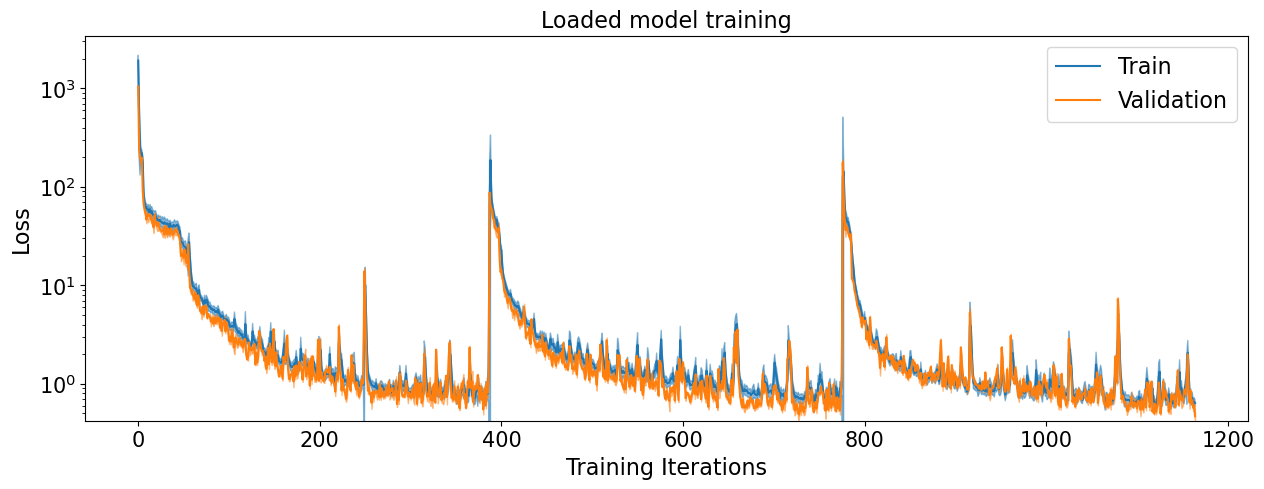

In [3]:
dic = trainer.load('best_model.trch')
trainer.gpt_model.eval()
miniGPT.plot_utils.model_numbers(generator_vit,N,n_layers,D, n_heads)
miniGPT.plot_utils.plot_losses(dic)

In [4]:
generator_vit.prediction_head = lambda x,y: x
dict_outputs = np.load(osp.join(data_dir,'airfoil_coeffs.npy'),allow_pickle=True).item()

In [5]:
x_train, y_train = gather_finetuning_data(dict_outputs,train_dataset,generator_vit,
                                      image_size,image_size,P,
                                        batch_size=16)
x_val, y_val = gather_finetuning_data(dict_outputs,val_dataset,generator_vit,
                                      image_size,image_size,P,
                                        batch_size=16)

In [6]:
y_mean, y_std = y_train.mean(0,keepdim=True), y_train.std(0,keepdim=True)
y_train = (y_train-y_mean)/y_std
y_val = (y_val-y_mean)/y_std

In [7]:
class Downblock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=6,use_norm=True,stride=2,pad=2):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, 
                              kernel_size=kernel_size, stride=stride, padding=pad, bias=False)
        if use_norm:
            self.norm = nn.BatchNorm2d(out_channels)
        else:
            self.norm = nn.Identity()
        self.relu = nn.LeakyReLU(0.2, True)
    def forward(self, x):
        x = self.conv(x)
        x = self.norm(x)
        x = self.relu(x)
        return x

class Finetuner(nn.Module):
    def __init__(self,in_channels,out_dim,width):
        super().__init__()
        self.conv_layers = nn.Sequential(
            Downblock(in_channels,width),
            Downblock(width,width),
            Downblock(width,width),
            Downblock(width,width),
            nn.Conv2d(width, 128, int(image_size/16), stride=1, padding=0))
        self.fc_layers = nn.Sequential(nn.Linear(128,128),nn.ReLU(),
                                      nn.Linear(128,128),nn.ReLU(),
                                      nn.Linear(128,2))
    def forward(self,x):
        x = self.conv_layers(x)
        return self.fc_layers(x.flatten(1))

In [8]:
finetuning_model = Finetuner(3,2,32).cuda()

In [9]:
from torch.utils.data import DataLoader, TensorDataset
train_loader = DataLoader(TensorDataset(x_train.cuda(),y_train.cuda()),
                         batch_size=32)
val_loader = DataLoader(TensorDataset(x_val.cuda(),y_val.cuda()),
                         batch_size=32)
opt = torch.optim.Adam(finetuning_model.parameters(),lr=3e-4,weight_decay=1e-4)
losses = []
val_losses = []
epoch_val_losses = [torch.inf]
epoch_losses = []
patience = 10
lossfunc = nn.MSELoss()

In [10]:
i_e = 0
while patience > (i_e-np.argmin(epoch_val_losses)):
    tmp_losses = []
    for x,y in train_loader:
        opt.zero_grad()
        pred = finetuning_model(x)
        
        loss = lossfunc(pred,y)
        loss.backward()
        opt.step()
        tmp_losses.append(loss.item())
    losses.extend(tmp_losses)
    epoch_losses.append(np.mean(tmp_losses))
    tmp_losses = []
    for x,y in val_loader:
        with torch.no_grad():
            pred = finetuning_model(x)
            loss = lossfunc(pred,y)
            tmp_losses.append(loss.item())
    val_losses.extend(tmp_losses)
    epoch_val_losses.append(np.mean(tmp_losses))
    i_e+=1
    print(f'Epoch : {i_e}, Loss : {losses[-1]:.3e}, Val : {val_losses[-1]:.3e}')

Epoch : 1, Loss : 5.351e-02, Val : 6.533e-02
Epoch : 2, Loss : 6.316e-02, Val : 5.629e-02
Epoch : 3, Loss : 4.084e-02, Val : 4.754e-02
Epoch : 4, Loss : 1.908e-02, Val : 3.241e-02
Epoch : 5, Loss : 1.584e-02, Val : 3.449e-02
Epoch : 6, Loss : 1.441e-02, Val : 2.490e-02
Epoch : 7, Loss : 2.030e-02, Val : 2.153e-02
Epoch : 8, Loss : 7.760e-03, Val : 1.614e-02
Epoch : 9, Loss : 2.530e-02, Val : 2.949e-02
Epoch : 10, Loss : 7.250e-03, Val : 1.154e-02
Epoch : 11, Loss : 2.460e-02, Val : 2.731e-02
Epoch : 12, Loss : 2.978e-02, Val : 2.974e-02
Epoch : 13, Loss : 2.814e-02, Val : 1.454e-02
Epoch : 14, Loss : 2.604e-02, Val : 3.209e-02
Epoch : 15, Loss : 1.649e-02, Val : 2.094e-02
Epoch : 16, Loss : 8.273e-03, Val : 3.107e-02
Epoch : 17, Loss : 7.857e-03, Val : 8.405e-03
Epoch : 18, Loss : 9.845e-03, Val : 4.971e-02
Epoch : 19, Loss : 1.017e-02, Val : 1.341e-02
Epoch : 20, Loss : 1.298e-02, Val : 4.248e-02
Epoch : 21, Loss : 3.343e-03, Val : 2.474e-02
Epoch : 22, Loss : 1.531e-02, Val : 2.878e-

In [11]:
pred = finetuning_model(x_val.cuda()).detach().cpu().numpy()

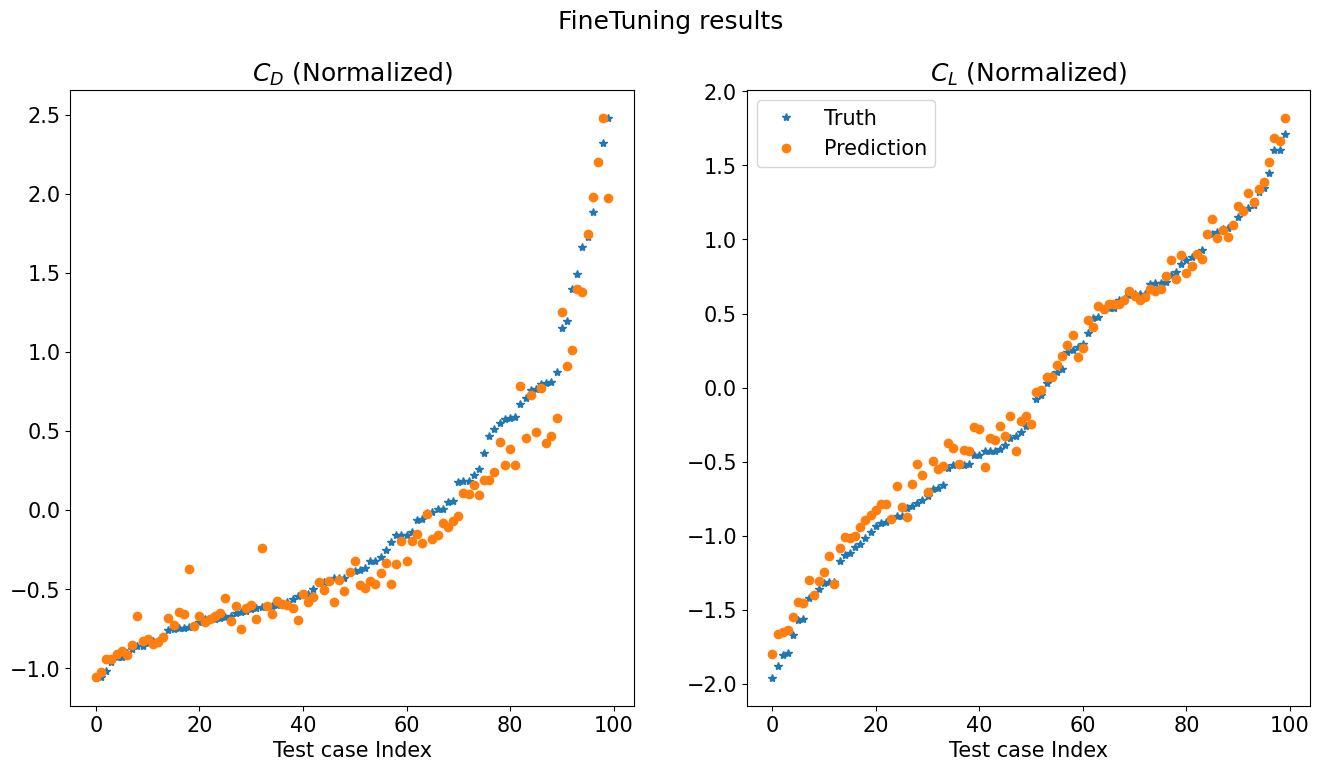

In [15]:
idx = np.random.choice(x_val.shape[0])
idx_0 = np.argsort(y_val[:,0])
idx_1 = np.argsort(y_val[:,1])

fig, (ax1,ax2) = plt.subplots(ncols=2,figsize=(16,8))
fig.suptitle('FineTuning results')
ax1.set_title(r'$C_D$ (Normalized)')
ax1.plot(y_val[idx_0,0],'*')
ax1.plot(pred[idx_0,0],'o')
ax1.set_xlabel('Test case Index')

ax2.set_title(r'$C_L$ (Normalized)')
ax2.plot(y_val[idx_1,1],'*',label='Truth')
ax2.plot(pred[idx_1,1],'o',label='Prediction')
ax2.set_xlabel('Test case Index')
plt.legend()